### Exercise 1: Training a Feed-Forward Neural Network on MNIST

Now that we've covered the basics of neural networks, let's examine what a typical training process looks like. In this notebook, we'll go through the classic MNIST dataset.

The Modified National Institute of Standards and Technology (MNIST) set is a database of handwritten digits, containing 60,000 examples for training and 10,000 test examples. This is a classic test set for machine learning algorithms, and is widely-used as a benchmark for new learning algorithms.

In [ ]:
### Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

%matplotlib inline 

# We can designate a flag for gpu_support
# In this case we'll run everything on CPU,
# so we set the following flag to false.
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In lecture, we discussed simple neural network implementations. In this notebook, we specifically outline four typical steps in neural network training:

    1) Load your data appropriately into training, validation, and test sets.
    2) Define your network architecture 
    3) Define your optimization criterion and method
    4) Train and evaluate your model

### 1) Loading the MNIST Dataset
We normalize the inputs using the following transforms. In this case, the magic numbers 0.1307 and 0.3081 refer to the *mean* and *std* of the MNIST training set.

In this case, MNIST is already a toy dataset built into PyTorch, and are abstracted away for simplicity. In general, the dataset object can be customized for your own dataset needs. For your own custom datasets check out the PyTorch tutorial: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
train_dataset = datasets.MNIST('../data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
                               
test_dataset = datasets.MNIST('../data',
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [ ]:
train_dataset[3] # look at the third example in the dataset

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

The label for the image is 5


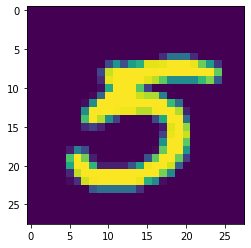

In [ ]:
i = 10543 # get the third example (change 'i')
plt.imshow(train_dataset[i][0].squeeze()) # get the first part of the third example

label = train_dataset[i][1]

print(f'The label for the image is {label}')

To fetch batches of data for training and testing, we use PyTorch's DataLoader object. We can specifically set a batch size, and designate other parameters for loading such as dataset shuffling.

In [ ]:
BATCH_SIZE = 128 # you can play around with this
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           num_workers=8)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False,
                                          num_workers=8)

The DataLoader grabs batches of a specified size, with both the inputs and the labels returned as a tuple.

In [ ]:
# grab a batch from the train loader
images, classes = next(iter(train_loader)) # one mini-batch of images and their class labels

In addition to reading the docs, it's usually helpful just to look at the sizes of the different batches and make sure they're compatible with the network layers you're using:

In [ ]:
images.shape, classes.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

 We can look at a few examples from the training set of MNIST, where each digit is a 28 x 28 simple digit image:

Above, we see that the train_loader object (PyTorch DataLoader) is an iterator that fetches a batch (size 128) of images, each 1 x 28 x 28 (1 channel corresponding to grayscale), along with a Tensor of labels (classes). Let's take a look at some of the images and labels:

Label: tensor(8)


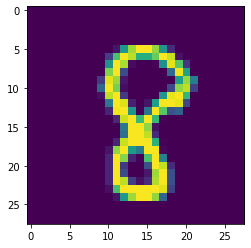

In [ ]:
example = 120
plt.imshow(np.squeeze(images)[example]) # plot the image
print('Label:', classes[example]) # display the digit label

### 2) Define your neural network architecture

With our dataset ready, we can define a simple neural network with two-hidden layers of 200 and 100 neurons. Importantly, each nn.Module object defines a forward pass, which can be flexibly used with standard Python control structures for training. Note that the network initializes with our designated layers

In [ ]:
#creates class called Net(base network for neural network models)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        """
        Create the individual layers inside the init function
        """
        self.fc1 = nn.Linear(28*28, 200) # MNIST images are 28 x 28
        self.fc2 = nn.Linear(200, 100) # from 200-node layer to 100 node layer
        self.fc3 = nn.Linear(100, 10) # from 100-node layer to output layer

    def forward(self, x):
        """
        We stitch together all of the layers in the forward call to define
        the computational graph.
        """
        x = F.relu(self.fc1(x))  # Pass the input through fc1 and apply relu nonlinearity
        x = F.relu(self.fc2(x))  # Pass the output from the 1st layer into the 2nd layer and apply relu
        x = self.fc3(x) # Pass from the second layer to the output layer
        return F.log_softmax(x, dim=1) # returns the log-softmax the final layer

In [ ]:
# Instantiate your model
model = Net()

# If using a gpu, you can instead uncomment the following:
#model.cuda() # the .cuda() call puts the model onto the GPU for training

In [ ]:
losses = []

In [ ]:
def train(model, 
          device, 
          train_loader, 
          optimizer,
          criterion,
          epoch,
          log_interval=128):
    model.train() # sets the parameters to be trainable
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28 * 28) # flatten into 1D array for dense nn
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item() # tally the number of correct
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    print('Train Epoch: {}, Train Accuracy: {}, Loss: {:.6f}'.format(
        epoch, correct/len(train_dataset), loss.item()))
    
def test(model, 
         device,
         criterion,
         test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 28 * 28) # flatten into 1D array for dense nn
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum the batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            predictions.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item() # tally the number of correct
            targets.append(target)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return torch.cat(targets), torch.cat(predictions)

### 3) Choose your criterion and optimizer.

In this case, we'll use the Adam optimizer with a preset learning rate of 0.01. Try out SGD with and without momentum, and see the effect on the speed of your training.

Our training criterion in this case will be `nll_loss`, which is the negative log likelihood loss. 

In [ ]:
optimizer = optim.Adam(model.parameters(), 
                      lr=0.001) # play with the learning rate
criterion = F.nll_loss

Each epoch iterates over the entire dataset one time, with each epoch split based on the size of the minibatches. Again, the gradients are accumulated from each backwards pass from each minibatch, and the optimizer updates the weights after each backwards pass.

In this example, we'll start with 10 epochs, but try using fewer or more, adjusting the learning rate (above), and using other optimizers. What happens if you use deep neural networks, or change the nonlinearities (logistic or tanh instead of relu)?

In [ ]:
epochs = 10 # play with the number of epochs

In [ ]:
for epoch in range(epochs):
    train(model,
      device,
      train_loader, 
      optimizer,
      criterion,
      epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325321
Train Epoch: 0 [16384/60000 (27%)]	Loss: 0.234866
Train Epoch: 0 [32768/60000 (55%)]	Loss: 0.359298
Train Epoch: 0 [49152/60000 (82%)]	Loss: 0.136927
Train Epoch: 0, Train Accuracy: 0.9168833333333334, Loss: 0.194669
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.081364
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.109887
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.183257
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.051912
Train Epoch: 1, Train Accuracy: 0.9657166666666667, Loss: 0.121332
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.059758
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.045853
Train Epoch: 2 [32768/60000 (55%)]	Loss: 0.067584
Train Epoch: 2 [49152/60000 (82%)]	Loss: 0.069756
Train Epoch: 2, Train Accuracy: 0.9764, Loss: 0.021502
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.054462
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.075104
Train Epoch: 3 [32768/60000 (55%)]	Loss: 0.036938
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.077354
Train Epoch: 3, Train Accuracy:

The loss from training converges quickly over ten epochs in this case. We can now check to see how these perform using our written test function:

In [ ]:
targets, predictions = test(model, device, criterion, test_loader)


Test set: Average loss: 0.0739, Accuracy: 9815/10000 (98%)



The model achives 97 percent accuracy on the test set!

### Question: 

 How does this accuracy change with less or more training? Play around with different models, architectures, and more to see whether you can improve the performance.

As a self-check, try to pull the examples from the test set that are correctly and incorrectly classified and plot them. Do they make sense?

In [ ]:
incorrects = np.where(np.array(predictions).T != np.array(targets))[1] # grab the incorrects

True label is 7, the predicted label is tensor([9])


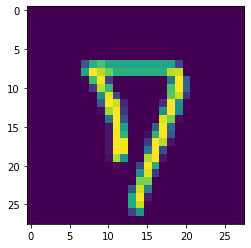

In [ ]:
i = 34 # play with this number and talk about it

incorrect_example = incorrects[i]
incorrect_example
print(f'True label is {targets[incorrect_example]}, the predicted label is {predictions[incorrect_example]}')
plt.imshow(test_dataset[incorrect_example][0].squeeze())

### Evaluation metrics: Confusion matrix





In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(targets, predictions)

array([[ 971,    0,    1,    0,    0,    2,    2,    1,    3,    0],
       [   0, 1134,    0,    1,    0,    0,    0,    0,    0,    0],
       [   0,    2, 1015,    3,    2,    0,    1,    3,    5,    1],
       [   0,    0,    2,  990,    0,   11,    0,    3,    3,    1],
       [   1,    0,    3,    1,  967,    2,    2,    1,    0,    5],
       [   2,    0,    0,    1,    1,  884,    2,    0,    1,    1],
       [   5,    3,    1,    1,    4,    3,  941,    0,    0,    0],
       [   1,    2,    5,    3,    2,    1,    0, 1006,    1,    7],
       [   5,    1,    4,   10,    4,    9,    0,    3,  936,    2],
       [   3,    2,    1,    5,   10,   13,    0,    3,    1,  971]])

### After self-checking and performing evaluation meterics: 

What numbers are the network having a hard time classfying? 

What number does the network classify the best? 